<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4_Nuclear/blob/main/Lab4_Poisson_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chisquare, poisson, linregress
from sklearn.linear_model import LinearRegression

# Get geiger-mueller sensor data

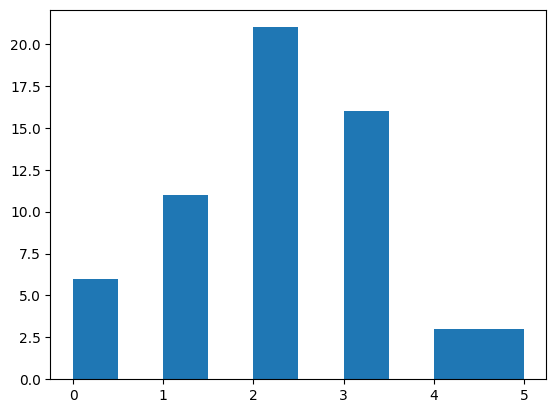

In [19]:
URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_14/1_Background.tsv'
#URL = 'https://raw.githubusercontent.com/tphlabs/data/main/Lab4_Nuclear/2023_12_13/Co60_shelf10_101measurements.tsv'
s = np.genfromtxt(URL, delimiter='\t', skip_header=11, usecols=2, dtype='int')

plt.hist(s);

In [20]:
I_background = s.mean() / 10
print(f'Background intensity I {I_background:.2f} counts/s')

Background intensity I 0.21 counts/s


# is it like Poisson distribution?

## Test by $\chi_2$ criterion

$$
\chi^2 =  \sum_k \frac{(O_k - E_k)^2}{E_k}
$$

$$ \tilde \chi^2 = \chi^2 / d,$$
where $d$ - number degrees of freedom.

Refer to [Taylor, J.R. (1997) An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.]

This is Poisson distribution with likelihood 10%
Chi2 obtained: 1.58 (for likelihood should be less than 1)


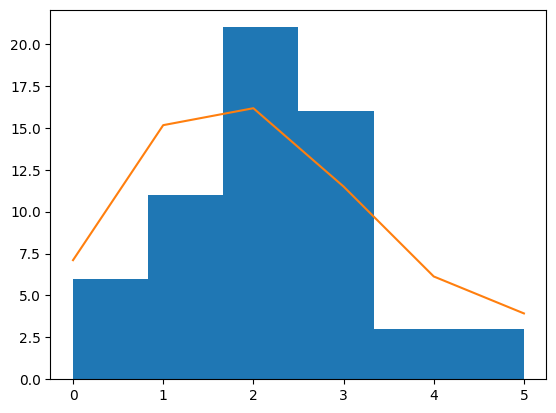

In [21]:
# s = poisson.rvs(2.13, size=100) # Synthetic data

mean_intencity = np.mean(s)
total_events = len(s)

observed = np.bincount(s)
bins = [bin for bin in range(len(observed))]
poi = np.array([poisson(mean_intencity).pmf(bin)  for bin in bins])
# add to last bin right tail probability P(x > x_max)
poi[-1] += 1 - poisson(mean_intencity).cdf(bins[-1])
expected = poi * total_events

#plt.plot(bins, observed, '.')
plt.hist(s, len(bins))
plt.plot(bins, expected)

# calculate chi2
chi2, pvalue = chisquare(observed, expected, ddof=2) # ddof = 2: total and mean values have been taken out of data
DOF = len(bins) - 2
chi2_obtainted = chi2/DOF
print(f'This is Poisson distribution with likelihood {pvalue*100:.0f}%')
print(f'Chi2 obtained: {chi2_obtainted:.2f} (for likelihood should be less than 1)')

## Test by 3rd moment criterion

In [22]:
k3 = (s - s.mean())**3
K3 = k3.sum()/(total_events-1)
s.mean(), s.std(), K3

(2.1333333333333333, 1.2174654911833116, 0.44549905838041454)

In [23]:
# relative error in intensity
s.mean(), s.std()/np.sqrt(total_events)

(2.1333333333333333, 0.15717411906450662)

In [24]:
errK3 = np.sqrt(k3.var() / (total_events - 1))
K3, errK3

(0.44549905838041454, 0.8192547233533447)

# Inverse square law

$$
I \propto \frac{1}{r^2}\, \implies \, r \propto \frac{1}{\sqrt I}
$$

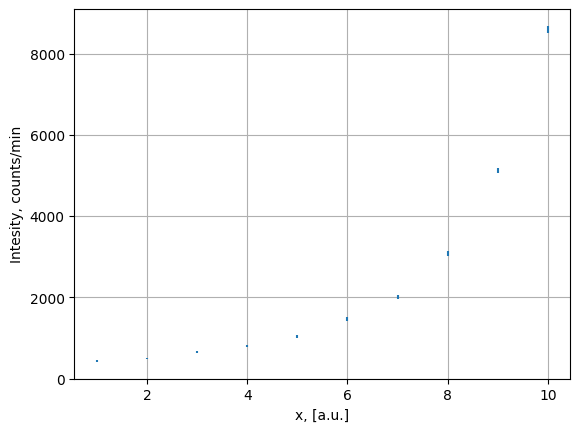

In [25]:
measurements = '''
1 429
2 491
3 646
4 805
5 1033
6 1465
7 2000
8 3077
9 5121
10 8587
'''
data = np.genfromtxt(measurements.splitlines())
x, I = data.T
Ierr = np.sqrt(I)

plt.errorbar(x, I, yerr=Ierr, linestyle='')
plt.xlabel('x, [a.u.]')
plt.ylabel('Intesity, counts/min')
plt.grid()


Offset $r = a -x$  

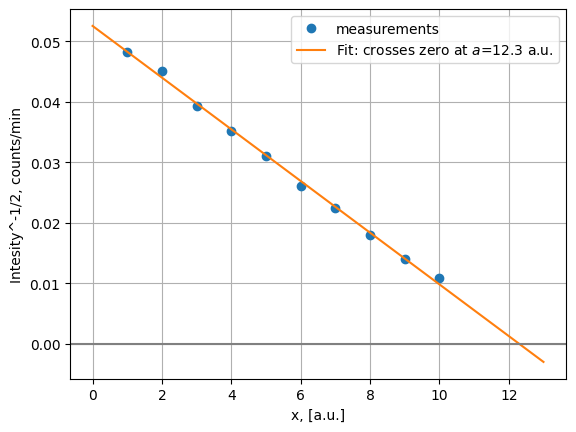

In [26]:
I_inv = 1/np.sqrt(I)
xspace = np.linspace(0, 13)

plt.plot(x, I_inv, 'o', label='measurements')
plt.xlabel('x, [a.u.]')
plt.ylabel('Intesity^-1/2, counts/min')

fit = linregress(x, I_inv)
a = -fit.intercept / fit.slope
plt.plot(xspace, fit.intercept + fit.slope * xspace, label=fr'Fit: crosses zero at $a$={a:.1f} a.u.')
plt.axhline(0, color='gray')
plt.grid()
plt.legend()


Proportionality test

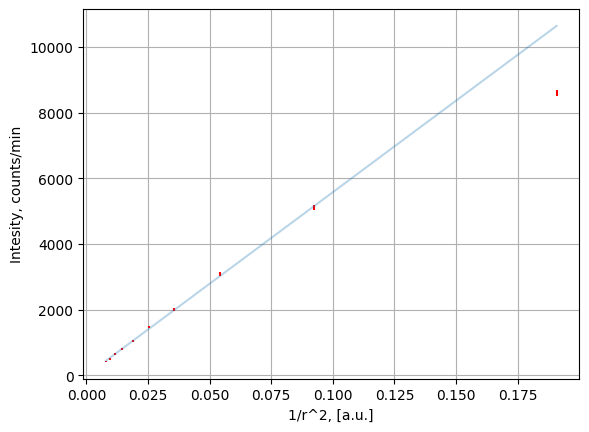

In [27]:
r = a - x
Ierr = np.sqrt(I)

plt.errorbar(1/r**2, I, yerr=Ierr, color='red', linestyle='', label='measurements')
plt.xlabel('1/r^2, [a.u.]')

lr = LinearRegression(fit_intercept=False)

lr.fit(1/r[:-1].reshape(-1, 1)**2, I[:-1])
plt.plot(1/r**2, lr.coef_ /r**2, alpha=0.3, label='linear fit')

plt.ylabel('Intesity, counts/min')
plt.grid()


# Attenuation
$$I = I_0 e^{-\mu d}$$

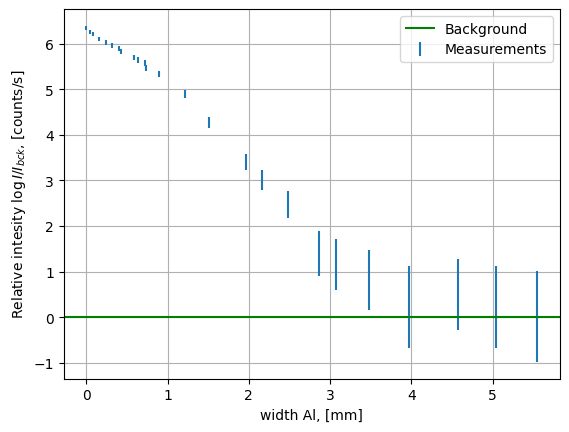

In [28]:
# colums 1 and 2 - width of aluminum plates between radiation source and GM intensity sensor (1e-6m)
# column 2 - Intensity counts/min
measurements = '''
2480 3070  13
2480 0     152
400 240    3592
400 320 3381
0  0   7280
3070 0 41
2160 0 259
1970 0 386
1510 0 913
1210 0 1716
900 0 2666
740 0 3041
590 0 3796
430 0 4362
400 0 4635
320 0 4918
240 0 5268
160 0 5675
80 0 6345
40 0 6593
3070 900 16
3070 1970 16
1970 900 52
1970 1510 29
3070 1510 21
'''
data = np.genfromtxt(measurements.splitlines())
d1, d2, I = data.T
d = d1 + d2
I /= 60 # counst/min -> counts/s
I_rel = I / I_background # relative
I_err = np.sqrt(I_rel)

plt.errorbar(d*1e-3, np.log(I_rel), yerr=I_err/I_rel, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $\log I/I_{bck}$, [counts/s]')
plt.axhline(0, color='green', label='Background')
plt.grid()
plt.legend()


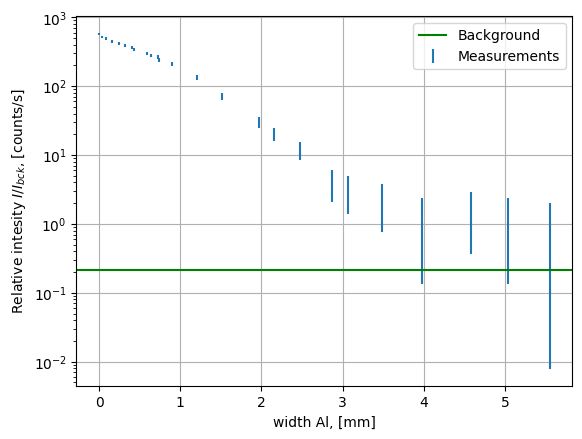

In [12]:
plt.errorbar(d*1e-3, I_rel, yerr=I_err, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $I/I_{bck}$, [counts/s]')
plt.axhline(I_background, color='green', label='Background')
plt.grid()
plt.yscale('log')
plt.legend()


# Attenuation coefficents $\mu$ of Aluminium

https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z13.html



In [13]:
coeff = '''
   1.00000E-03  1.185E+03  1.183E+03
   1.50000E-03  4.022E+02  4.001E+02
   1.55960E-03  3.621E+02  3.600E+02
   1.55960E-03  3.957E+03  3.829E+03
   2.00000E-03  2.263E+03  2.204E+03
   3.00000E-03  7.880E+02  7.732E+02
   4.00000E-03  3.605E+02  3.545E+02
   5.00000E-03  1.934E+02  1.902E+02
   6.00000E-03  1.153E+02  1.133E+02
   8.00000E-03  5.033E+01  4.918E+01
   1.00000E-02  2.623E+01  2.543E+01
   1.50000E-02  7.955E+00  7.487E+00
   2.00000E-02  3.441E+00  3.094E+00
   3.00000E-02  1.128E+00  8.778E-01
   4.00000E-02  5.685E-01  3.601E-01
   5.00000E-02  3.681E-01  1.840E-01
   6.00000E-02  2.778E-01  1.099E-01
   8.00000E-02  2.018E-01  5.511E-02
   1.00000E-01  1.704E-01  3.794E-02
   1.50000E-01  1.378E-01  2.827E-02
   2.00000E-01  1.223E-01  2.745E-02
   3.00000E-01  1.042E-01  2.816E-02
   4.00000E-01  9.276E-02  2.862E-02
   5.00000E-01  8.445E-02  2.868E-02
   6.00000E-01  7.802E-02  2.851E-02
   8.00000E-01  6.841E-02  2.778E-02
   1.00000E+00  6.146E-02  2.686E-02
   1.25000E+00  5.496E-02  2.565E-02
   1.50000E+00  5.006E-02  2.451E-02
   2.00000E+00  4.324E-02  2.266E-02
   3.00000E+00  3.541E-02  2.024E-02
   4.00000E+00  3.106E-02  1.882E-02
   5.00000E+00  2.836E-02  1.795E-02
   6.00000E+00  2.655E-02  1.739E-02
   8.00000E+00  2.437E-02  1.678E-02
   1.00000E+01  2.318E-02  1.650E-02
   1.50000E+01  2.195E-02  1.631E-02
   2.00000E+01  2.168E-02  1.633E-02
'''
data = np.genfromtxt(coeff.splitlines())
# energy [MeV]
# mu_gamma, mu_beta [cm^2/g]
energy, mu_gamma, mu_beta = data.T

## Stroncium-90 decay
![image.png](https://radioactivity.eu.com/static/bd2ac4b2ed7ce11af31e688bfcadc8b0/d1f95/Diagramme_Strontium_En.jpg)

In [14]:
E_st90 = 0.546 # MeV
# find nearest mu to Str90 decay energy
idx = np.abs(energy - E_st90).argmin()
rho_Al = 2.7 # g/cm^3
mu_gamma_str90 = mu_gamma[idx] * rho_Al
mu_beta_str90 = mu_beta[idx]   * rho_Al


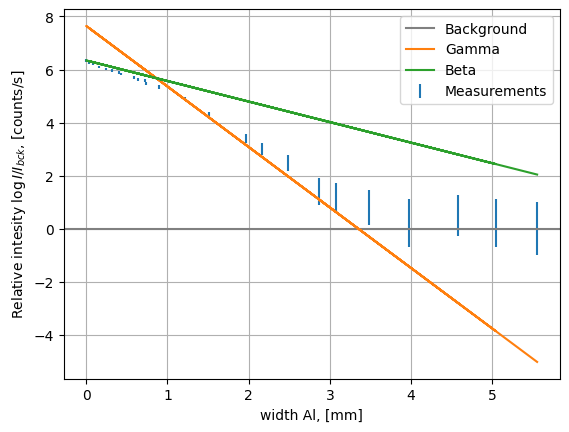

In [15]:
gamma_offset = 1
I_model_gamma = gamma_offset * np.max(I_rel) * np.exp(-mu_gamma_str90 * d*1e-2)
I_model_beta = np.max(I_rel) * np.exp(-mu_beta_str90 * d*1e-2)
plt.errorbar(d*1e-3, np.log(I_rel), yerr=I_err/I_rel, linestyle='', label='Measurements')
plt.xlabel('width Al, [mm]')
plt.ylabel(r'Relative intesity $\log I/I_{bck}$, [counts/s]')
plt.axhline(0, color='gray', label='Background')
offset = 1.3
plt.plot(d*1e-3,  offset + np.log(I_model_gamma), label='Gamma')
plt.plot(d*1e-3, np.log(I_model_beta), label='Beta')
plt.grid()
plt.legend()